# Analysis of the drag coefficient

The computed drag coefficient of ellipsoidal, spherical cap, and dimpled ellipsoidal bubble is compared for the three different simulation approaches followed here:

- two-phase VOF flow solver
- single-phase flow solver with Dirichlet boundary condition at the bubble surface
- single-phase flow solver with free slip boundary condition at the bubble surface

In [1]:
import helper_module as hm
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline

data_path = "../data/"
output_path = "../output/"

def savefig(name):
    plt.savefig(output_path + name + ".png", bbox_inches="tight")
    plt.savefig(output_path + name + ".pdf", bbox_inches="tight")

In [2]:
# Basilisk rise velocity, see notebook 'basilisk_2D_velocity_field.ipynb'
U_b = [2.76881841, 0.80718755, 0.55113413]
# c_d = 4/3/U_b^2
# d_b = 1; g = 1; rho_l = 1;
c_d = [4.0 / 3.0 / U**2 for U in U_b]
print(c_d)

[0.1739201049168398, 2.0463967014234834, 4.389591678828082]


In [3]:
cases = ["wa18_l16", "scap_l16", "dell_l17"]
bcs = ["1", "slip_1"]
columns = ["t", "snGradT", "A"]

of_post = "postProcessing/forceCoeffs/0/coefficient.dat"
dir_files = [data_path + "single_phase/{}/flow_steady_1/".format(case) + of_post for case in cases]
slip_files = [data_path + "single_phase/{}/flow_steady_slip_1/".format(case) + of_post for case in cases]

dir_data = {}
slip_data = {}
names = ["it", "c_d"]
for i, case in enumerate(cases):
    dir_data[case] = pd.read_csv(dir_files[i], sep="\t", header=0, skiprows=range(0, 12), usecols=[0, 1], names=names)
    slip_data[case] = pd.read_csv(slip_files[i], sep="\t", header=0, skiprows=range(0, 12), usecols=[0, 1], names=names)
    

dir_data["dell_l17"].head()

,it,c_d
0,1,20.371927
1,2,6.905479
2,3,5.716217
3,4,5.203792
4,5,5.020034


## Plot drag over time

Text(0.5,0,'last 500 iterations')

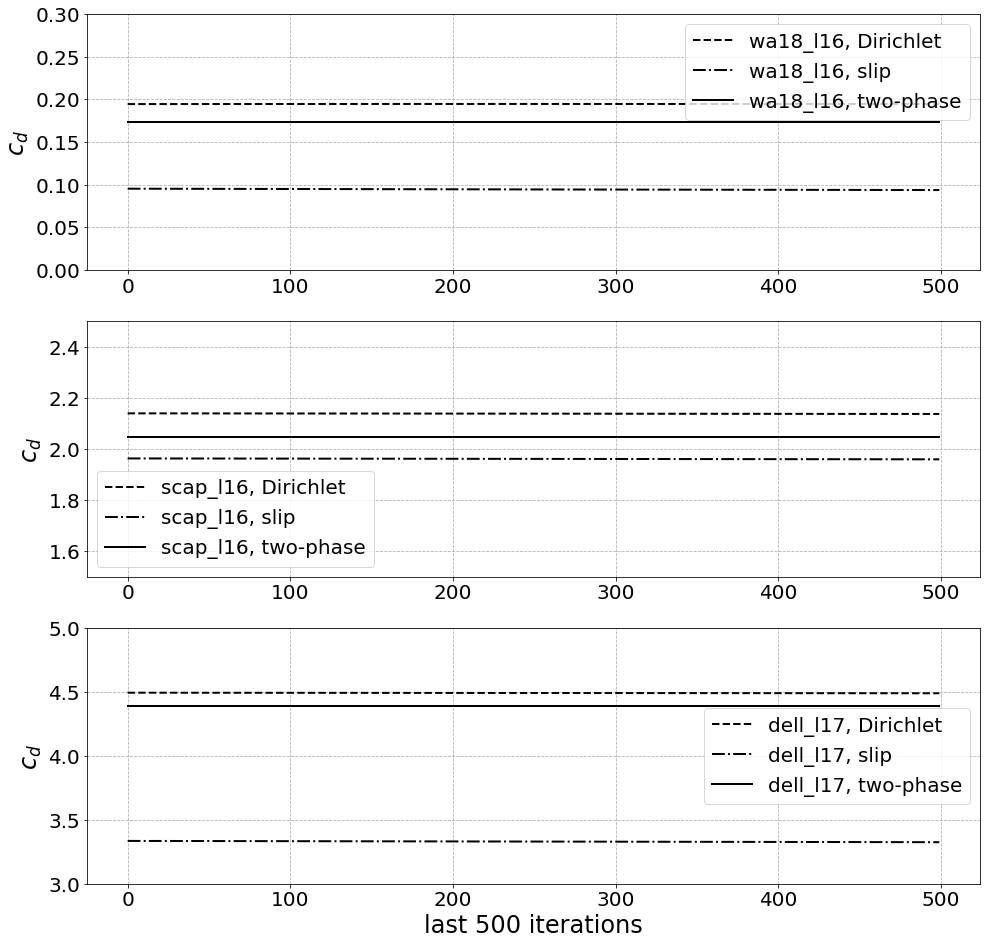

In [4]:
rc('text', usetex=False)
fig, axarr = plt.subplots(3, 1, figsize=(hm.figure_width, 16))

y_min = [0.0, 1.5, 3.0]
y_max = [0.3, 2.5, 5.0]

n_iter = 500

for i, case in enumerate(cases):
    axarr[i].plot(range(n_iter), dir_data[case].c_d[-n_iter:], label=case + ", Dirichlet", ls="--", lw=2, color="k")
    axarr[i].plot(range(n_iter), slip_data[case].c_d[-n_iter:], label=case + ", slip", ls="-.", lw=2, color="k")
    axarr[i].plot([0.0, n_iter-1], [c_d[i], c_d[i]], label=case + ", two-phase", ls="-", lw=2, color="k")
    axarr[i].set_ylabel(r"$c_{d}$", fontsize=hm.fontsize_label)
    axarr[i].set_ylim(y_min[i], y_max[i])
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].grid(True, ls="--")
    axarr[i].legend(fontsize=hm.fontsize_legend)
    
axarr[-1].set_xlabel(r"last {} iterations".format(n_iter), fontsize=hm.fontsize_label)

## Drag comparison two-phase, Dirichlet, slip

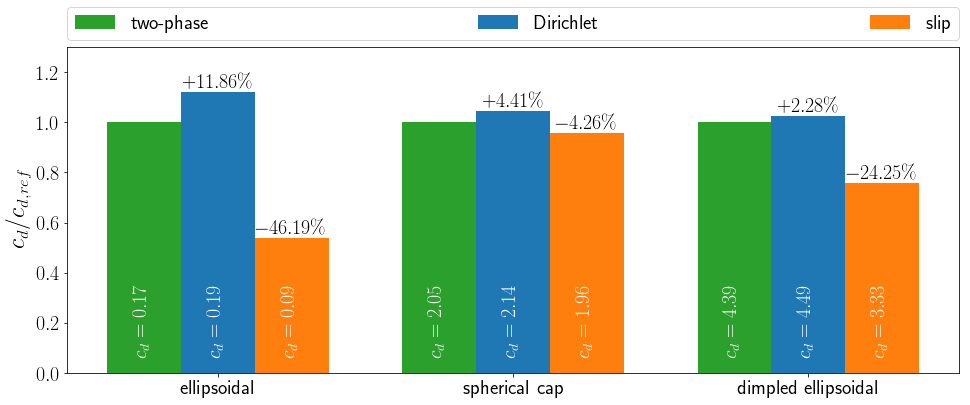

In [5]:
rc('text', usetex=True)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

c_d_dir = []
c_d_slip = []
for case in cases:
    c_d_dir.append(dir_data[case].c_d.values[-1])
    c_d_slip.append(slip_data[case].c_d.values[-1])

# bar plot of global Sh
x = np.linspace(1, 5, 3)
ax.bar(x, [1]*3, width=0.5, color="C2", label=r"two-phase")
ax.bar(x+0.5, np.asarray(c_d_dir) / np.asarray(c_d), width=0.5, color="C0", label=r"Dirichlet")
ax.bar(x+1.0, np.asarray(c_d_slip) / np.asarray(c_d), width=0.5, color="C1", label=r"slip")

# reference value, difference Dirichlet / slip
diff_dir = [(d - tp) / tp * 100 for d, tp in zip(c_d_dir, c_d)]
diff_slip = [(d - tp) / tp * 100 for d, tp in zip(c_d_slip, c_d)]
off = 0.02
for i, x_i in enumerate(x):
    ax.text(x_i, 0.3, r"$c_d={:1.2f}$".format(np.around(c_d[i], 2)), color="w", fontsize=hm.fontsize_legend,
           rotation=90, ha="center")
    ax.text(x_i+0.5, 0.3, r"$c_d={:1.2f}$".format(np.around(c_d_dir[i], 2)), color="w", fontsize=hm.fontsize_legend,
           rotation=90, ha="center")
    ax.text(x_i+1.0, 0.3, r"$c_d={:1.2f}$".format(np.around(c_d_slip[i], 2)), color="w", fontsize=hm.fontsize_legend,
           rotation=90, ha="center")
    ax.text(x_i + 0.5, c_d_dir[i] / c_d[i] + off, r"${:+1.2f}\%$".format(np.round(diff_dir[i], 2)),
            ha="center", fontsize=hm.fontsize_legend)
    ax.text(x_i + 1.0, c_d_slip[i] / c_d[i] + off, r"${:+1.2f}\%$".format(np.round(diff_slip[i], 2)),
            ha="center", fontsize=hm.fontsize_legend)

ax.tick_params(which='major', labelsize=hm.fontsize_tick)
ax.set_ylabel(r"$c_d/c_{d,ref}$", fontsize=hm.fontsize_label)
ax.set_ylim(0.0, 1.3)
ax.set_xticks(x+0.5)
ax.set_xticklabels(["ellipsoidal", "spherical cap", "dimpled ellipsoidal"])
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
          ncol=3, mode="expand", borderaxespad=0., fontsize=hm.fontsize_legend)
savefig("c_d_dirichlet_vs_slip")